<a href="https://colab.research.google.com/github/llcorrea/TesteDados/blob/main/TesteDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task description**

**Objetivo:**

Estimar o tempo em que um pulverizador finaliza uma ordem de serviço ($T_t$). 

O tempo ($T_t$) se divide em:
* Efetivo (E): tempo em que o equipamento encontra-se trabalhando dentro do talhão.
* Manobra (M): Tempo em que o equipamento encontra-se indo de uma linha para a próxima.
* Deslocamento (D): Tempo em que o equipamento encontra-se deslocando dentro do talhão. (Sem estar em efetivo nem em manobra).
* Parada (F): Tempo em que o equipamento encontra-se parado. Isto pode ser por dissimiles motivos: aguardando produto, abastecimento, manutenção.

> Neste problema desconsideraremos o tempo de parada, logo:
>
> $T_t = E + D+ M$

Todos os tempos encontram-se em segundos.

Outros dados de interesse:
* **boom_len:** Largura do implemento do pulverizador (pé).  
* **ACRES:** Área trabalhada dos talhões da ordem de serviço (acres).
* **Velocidade média de efetivo:** 24 km/h.
* Os outros campos do dataset são índices que caracterizam os talhões.

**O dataset fora fornecido para o teste.**

#**Importing libs**

In [380]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

#**Useful functions**

In [381]:
def dataset_description(df_obj):
  ##describe the dataset
  print('Dataset shape: %s\n' % (df_obj.shape, ))
  print('Dataset columns: %s\n' % df_obj.columns)

  display(df_obj)
  #display(df_obj.head())
  #display(df_obj.tail())
  
  print('\nColumns description:\n')
  display(df_obj.info())
  display(df_obj.describe())
  
  print('\nNull values:\n')
  display(df_obj.isnull().sum())

In [382]:
def calc_regression_metrics(model_name, real_y, prediction):
  display(model_name+' prediction | Regression metric:')
  print('r2:', r2_score(real_y, prediction))
  print('MAE:', mean_absolute_error(real_y, prediction))
  print('MSE:', mean_squared_error(real_y, prediction))

#**Loading dataset**

In [383]:
try:
  train_data = pd.read_csv('problems_dataset.csv')  
except:
  uploaded = files.upload()
  train_data = pd.read_csv('problems_dataset.csv')


# **EDA step**

> **Total de dados:** 113 registros\
> **Total de colunas:** 23 colunas, considerando uma coluna de índices\
> **Total de atributos:** 22 features, considerando uma coluna de chaves\
> **Variável alvo (*target*):** A variável alvo (*tempo_servico*), definida abaixo, representa o tempo em que um pulverizador finaliza uma ordem de serviço ($T_t$), onde $T_t$ é composto pela soma de outras três variáveis do dataset: $T_t = E + D+ M$. 

* Cada registro representa uma ordem de serviço previamente realizada.

* Assim, nesse teste, a variável alvo (*tempo_servico*) é utilizada na formulação do problema de ML supervisionado, o qual visa estimar o tempo em que um dado pulverizador finalizará uma ordem de serviço, considerando ordens de serviço anteriores por meio das variáveis independentes do dataset.

* **Os atributos *E, D, M e F* são excluídos do conjunto de features de treinamento, pois compõe a variável alvo a ser estimada.**

* **Todos os atributos, com exceção da *KEY*, são atributos numéricos.**

> **Dados ausentes ou nulos:**

* **Não há dados ausentes ou nulos em nenhuma das colunas do dataset.**

> **Atributo sem variação: (remover)**
* *RATE_GAL_ACRES* (valores zerados)

> **Atributos a serem normalizados:**
* *ACRES, RATE_LBS_ACRES, ITER, OBJECTID, num_polygons, boom_len, AREA_TOTAL*

In [384]:
dataset_description(train_data)

Dataset shape: (113, 23)

Dataset columns: Index(['Unnamed: 0', 'KEY', 'ACRES', 'RATE_GAL_ACRES', 'RATE_LBS_ACRES', 'D',
       'E', 'F', 'M', 'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio',
       'rectangularity', 'eliptic_variance', 'circular_variance',
       'compactness', 'perimeter', 'num_polygons', 'weighted_convexity',
       'boom_len', 'AREA_TOTAL', 'AREA_RATIO'],
      dtype='object')



,Unnamed: 0,KEY,ACRES,RATE_GAL_ACRES,RATE_LBS_ACRES,D,E,F,M,ITER,OBJECTID,convexity,principal_axis_ratio,rectangularity,eliptic_variance,circular_variance,compactness,perimeter,num_polygons,weighted_convexity,boom_len,AREA_TOTAL,AREA_RATIO
0,0,2020-10-08|8117|3604 - C51 - TG 7300,8.60,0.0,2000.04,4.0,231.0,117.0,1.0,0,8117.0,0.997092,0.143203,0.923280,0.010304,0.293760,0.763728,0.008844,1,0.997092,80,8.971335,0.958609
1,1,2020-10-09|4286|3203 - L90 - TG 7300,56.93,0.0,316.95,1796.0,713.0,2573.0,19.0,0,4286.0,0.497117,0.610057,0.718599,0.134875,0.080754,0.426239,0.040843,3,0.859118,85,59.594696,0.955286
2,2,2020-10-12|5477|3203 - L90 - TG 7300,40.77,0.0,319.87,134.0,1309.0,0.0,470.0,0,5477.0,0.743512,0.647334,0.884944,0.120287,0.068687,0.641314,0.022984,1,0.743512,85,42.723583,0.954274
3,3,2020-10-13|3101|3203 - L90 - TG 7300,38.80,0.0,406.67,678.0,1563.0,0.0,255.0,0,3101.0,0.999988,0.563219,0.947371,0.013893,0.024228,0.902149,0.015932,1,0.999988,85,40.622692,0.955131
4,4,2020-10-08|575|3003 - 6S - TG 7300,6.13,0.0,248.11,20.0,342.0,159.0,0.0,0,575.0,0.995826,0.025848,0.827361,0.041749,0.932529,0.614919,0.009249,1,0.995826,80,6.360773,0.963719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,2020-10-08|470|3003 - 6S - TG 7300,28.84,0.0,258.01,65.0,1557.0,2323.0,0.0,1,470.0,0.817520,0.746394,0.850457,0.041219,0.040941,0.715819,0.017237,2,0.995556,80,29.938136,0.963320
109,109,2020-10-08|1214|3003 - 6S - TG 7300,68.47,0.0,258.01,28.0,2878.0,355.0,0.0,1,1214.0,0.653959,0.435554,0.781076,0.089068,0.079620,0.525579,0.036183,3,0.998321,80,71.114013,0.962820
110,110,2020-10-19|7670|3001 - C36 - TG 6200,77.55,0.0,100.00,0.0,5.0,0.0,2.0,11,7670.0,0.984324,0.298417,0.979155,0.064777,0.069622,0.860303,0.023600,1,0.984324,70,81.061180,0.956685
111,111,2020-11-04|2701|3604 - C51 - TG 7300,13.81,0.0,450.01,2.0,474.0,0.0,0.0,19,2701.0,0.986982,0.086709,0.744301,0.031987,0.369848,0.676720,0.012661,1,0.986982,80,14.434266,0.956751



Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            113 non-null    int64  
 1   KEY                   113 non-null    object 
 2   ACRES                 113 non-null    float64
 3   RATE_GAL_ACRES        113 non-null    float64
 4   RATE_LBS_ACRES        113 non-null    float64
 5   D                     113 non-null    float64
 6   E                     113 non-null    float64
 7   F                     113 non-null    float64
 8   M                     113 non-null    float64
 9   ITER                  113 non-null    int64  
 10  OBJECTID              113 non-null    float64
 11  convexity             113 non-null    float64
 12  principal_axis_ratio  113 non-null    float64
 13  rectangularity        113 non-null    float64
 14  eliptic_variance      113 non-null    float64
 15  

None

,Unnamed: 0,ACRES,RATE_GAL_ACRES,RATE_LBS_ACRES,D,E,F,M,ITER,OBJECTID,convexity,principal_axis_ratio,rectangularity,eliptic_variance,circular_variance,compactness,perimeter,num_polygons,weighted_convexity,boom_len,AREA_TOTAL,AREA_RATIO
count,113.00000,113.000000,113.0,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,56.00000,56.360531,0.0,309.578142,174.530973,1860.283186,643.849558,92.628319,0.460177,3264.327434,0.845480,0.341616,0.768270,0.090263,0.211801,0.672206,0.027700,1.495575,0.893593,77.035398,60.618727,0.941329
std,32.76431,46.793619,0.0,210.074786,315.341370,1688.328328,1260.695027,240.563037,2.709228,2599.273516,0.178180,0.210566,0.159451,0.079703,0.313864,0.164445,0.022114,1.570509,0.132060,7.215966,49.193770,0.106287
min,0.00000,1.040000,0.0,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,65.000000,0.330061,0.025178,0.296838,0.008956,0.023967,0.241356,0.002924,1.000000,0.424034,60.000000,1.088398,0.295560
25%,28.00000,20.140000,0.0,225.000000,24.000000,685.000000,0.000000,0.000000,0.000000,1044.000000,0.742120,0.169594,0.684061,0.028517,0.072492,0.541255,0.014835,1.000000,0.824010,70.000000,21.030166,0.956764
50%,56.00000,47.370000,0.0,296.590000,48.000000,1557.000000,147.000000,0.000000,0.000000,2597.000000,0.928484,0.298417,0.800049,0.064777,0.115536,0.686326,0.023957,1.000000,0.951865,80.000000,51.457798,0.958836
75%,84.00000,77.120000,0.0,400.010000,180.000000,2335.000000,587.000000,19.000000,0.000000,4732.000000,0.995910,0.506028,0.884944,0.126408,0.194424,0.815395,0.030293,1.000000,0.996384,80.000000,82.041280,0.962556
max,112.00000,270.700000,0.0,2000.040000,1796.000000,9449.000000,7676.000000,1488.000000,19.000000,8117.000000,1.000000,0.790778,0.998288,0.411700,2.358658,0.908125,0.157214,12.000000,1.000000,85.000000,283.119214,1.147650



Null values:



Unnamed: 0              0
KEY                     0
ACRES                   0
RATE_GAL_ACRES          0
RATE_LBS_ACRES          0
D                       0
E                       0
F                       0
M                       0
ITER                    0
OBJECTID                0
convexity               0
principal_axis_ratio    0
rectangularity          0
eliptic_variance        0
circular_variance       0
compactness             0
perimeter               0
num_polygons            0
weighted_convexity      0
boom_len                0
AREA_TOTAL              0
AREA_RATIO              0
dtype: int64

**Análise das features mais relevantes:**

> **Feature *ACRES*:**\
> Área trabalhada dos talhões da ordem de serviço (acres).

* **Sem dados faltantes.**
* Valores desbalanceados, ordens de serviço variando entre 1.04 e 270.7 acres.
* 50% das ordens de serviço apresentam menos de 47.37 acres.
* 75% das ordens de serviço apresentam menos de 77.12 acres.

Total de valores da feature ACRES:
8.48      1
25.16     1
103.46    1
48.54     1
101.81    1
         ..
89.01     1
78.53     1
74.45     1
77.55     1
149.50    1
Name: ACRES, Length: 113, dtype: int64

Classes de valores únicos da feature ACRES:
[  8.6   56.93  40.77  38.8    6.13  29.53   8.18  41.41  13.47  66.45
  77.12  89.01  53.67 133.66 191.14  79.15   9.98  74.51  48.54 103.6
   1.04  16.48   1.83  12.45  15.72  16.68  59.45  49.03 119.45 116.34
 149.5  270.7  101.81  82.89  14.8   45.05  30.64  53.66  13.91  39.93
  50.49  82.31 166.01  44.    44.97  33.31  79.47  58.42  47.37  43.66
  90.91 221.95  67.53  19.69  25.16  22.26  15.42  73.44  63.78  17.03
  78.85  16.63  26.    63.    56.02  41.09  34.2  145.11  43.29  27.09
  83.59  15.83  68.45  17.33  56.46  29.    77.59  81.1   37.74  23.92
   1.81   8.48  67.83 111.17  74.45  30.05  36.28 116.83   7.78  78.53
  82.16  16.78   7.66  20.14  11.52  18.68   8.65  72.3   46.23 103.46
 177.89  71.41  58.11  60.23  20.31  52.

Text(0.5, 0, 'ACRE')

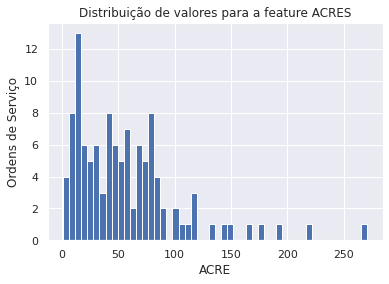

In [385]:
var='ACRES'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
ax=train_data[var].hist(bins=50)
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('ACRE')

> **Feature *boom_len*:**\
> Largura do implemento do pulverizador (pé).

* **Sem dados faltantes.**
* Valores desbalanceados, largura do implemento do pulverizador usado nas ordens de serviço do dataset varia entre 60 e 85 pés.
* A feature assume apenas quatro valores distintos (feature categórica): 80, 85, 70, 60.
* 75% das ordens de serviço apresentam largura do implemento do pulverizador menor do que 80 pés.

Total de valores da feature boom_len:
80    65
70    20
85    17
60    11
Name: boom_len, dtype: int64

Classes de valores únicos da feature boom_len:
[80 85 70 60]

count    113.000000
mean      77.035398
std        7.215966
min       60.000000
25%       70.000000
50%       80.000000
75%       80.000000
max       85.000000
Name: boom_len, dtype: float64 



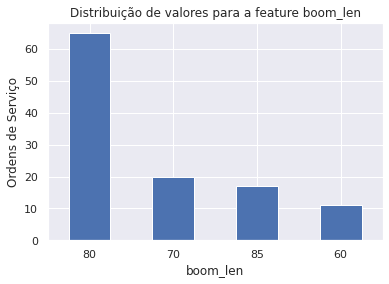

In [386]:
var='boom_len'
print('Total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts()))
#print('Porcentagem total de valores da feature %s:\n%s\n' % (var, train_data[var].value_counts(normalize=True))) #feature com valores desbalanceados
print('Classes de valores únicos da feature %s:\n%s\n'  % (var, train_data[var].unique())) #descrição dos valores únicos da feature
print(train_data[var].describe(), '\n')
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Distribuição de valores para a feature '+var)
ax.set_ylabel('Ordens de Serviço')
ax.set_xlabel('boom_len')
ax.tick_params(axis='x', labelrotation=0)

> **Relação entre as features *ACRES* e *boom_len*:**

* **Através dos gráficos, percebe-se que a largura do implemento do pulverizador não é a única responsável por definir a área trabalhada dos talhões, visto que existem ordens de serviço com o maior valor possível de boom_len (85 pés) e com valor de *ACRES* mais baixo.**

* **Assim, faz-se necessária a investigação dos outros atributos do dataset que caracterizam os talhões.**

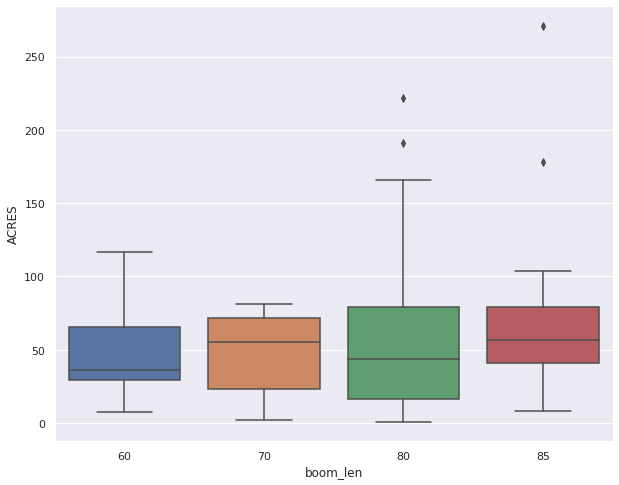

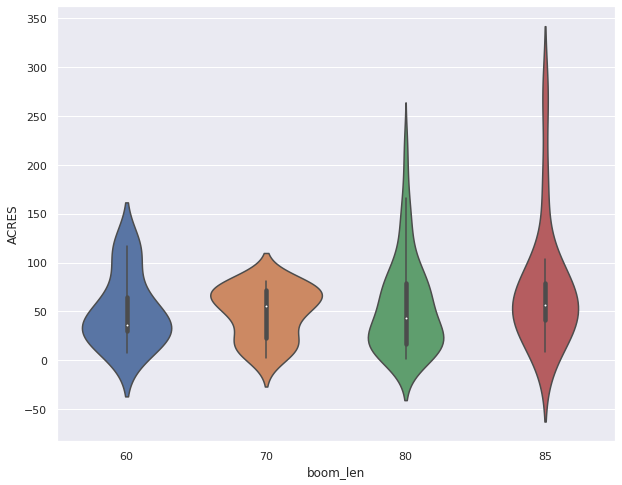

In [387]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(y='ACRES', x='boom_len', data=train_data)
plt.show()

sns.set()
plt.figure(figsize=(10, 8))
sns.violinplot(y='ACRES', x='boom_len', data=train_data)
plt.show()

**Correlação entre as features:**

> Determinação do grau de relacionamento entre duas features.

De forma mais evidente, nota-se alguns cenários de correlação entre os atributos: 
1. Corelação positiva entre as features *ACRES, E, perimeter e AREA_TOTAL*. Essas variáveis também apresentam leve correlação com as outras features responsáveis por formarem a variável alvo (*D e M*), o que pode indicar uma relevância maior para a estimativa do *target*.

2. Corelação positiva entre as features *compactness, convexity e weighted_convexity*. Essas variáveis apresentam leve correlação negativa com as features geradoras do target.

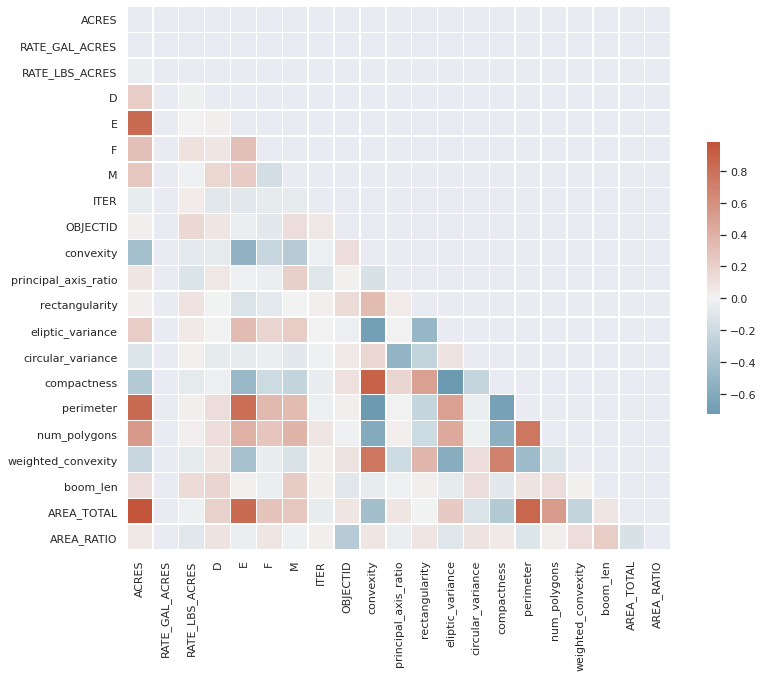

In [388]:
corr=train_data.iloc[:, 1:].corr()
#display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **ML steps**

> Problema a ser resolvido: Considerando os atributos do dataset, o modelo de ML visa estimar o tempo em que um pulverizador finaliza uma certa ordem de serviço de acordo com a variável alvo *tempo_servico*, gerada através da soma dos atributos *Efetivo (E)*, *Deslocamento (D)* e *Manobra (M)*.

* Visto que a variável alvo representa valores contínuos, usaremos modelos de regressão para o treinamento e estimação de valores.

**Etapas de ajuste do modelo de ML ao dataset:**
1. Definição das features utilizadas no modelo de ML.

2. Divisão da base em treino e validação (*data split*).

3. Ajuste dos dados de treino (*fit*).

4. Predição e cálculo da acurácia para o conjunto de validação/teste (*prediction* e *score*).

**Criação de novos atributos:**

* Criação da variável alvo *tempo_servico* através da soma das variáveis *E, D e M*.

* Criação da variável *eficiencia*, a qual visa descrever a relação (razão) entre os atributos ACRES, boom_len e a velocidade média de efetivo (24 km/h). Quanto maior o valor da variável criada, mais eficiente a ordem de serviço considerando apenas a área trabalhada dos talhões e a largura do implemento do pulverizador.

In [389]:
##criação da variável target tempo_servico
train_data['tempo_servico']=train_data['E']+train_data['D']+train_data['M']

##criação da variável de eficiência 
train_data['eficiencia']=train_data['ACRES']/train_data['boom_len']*24.0
display(train_data['eficiencia'].describe())

count    113.000000
mean      17.570784
std       14.145495
min        0.312000
25%        6.678000
50%       15.147000
75%       23.945143
max       76.432941
Name: eficiencia, dtype: float64

**Variáveis para o modelo de ML:**

X = features de treino (variáveis independentes)\
y = *target* (variável dependente)

* **Inicialmente todas as features do dataset serão utilizadas, exceto as features que compõe a variável alvo, feature de índices e chaves.**

In [390]:
#display(train_data.columns)

##features utilizadas no treinamento do modelo
features = ['ACRES', 'RATE_LBS_ACRES', 'ITER', 'OBJECTID', 'convexity', 'principal_axis_ratio', 'rectangularity', 'eliptic_variance', 'circular_variance', 'compactness', 'perimeter', 
       'num_polygons', 'weighted_convexity', 'boom_len', 'AREA_TOTAL', 'AREA_RATIO', 'eficiencia']

X = train_data[features]

##target a ser estimado
y = train_data['tempo_servico']

#display(X)
#display(y)

**Divisão do dataset em treino e validação/teste:**

> test_size = 0.25 -> Tamanho para a base de teste (validação). A proporção entre treino e teste varia de acordo com o volume de dados disponível.

> O modelo será testado seguindo a proporção de 25/75, o que significa que a base de teste será composta por 25% dos dados, e a base de treino será composta pelos 75% restantes.

In [391]:
##data split between train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=376) #test_size=0.3, 0.5

#display(train_X)
#display(val_X)
#display(train_y)
#display(val_y)

**Normalização de features:**

In [392]:
##normalização de algumas features fora de escala apontadas na etapa de EDA
norm_features = ['ACRES', 'RATE_LBS_ACRES', 'ITER', 'OBJECTID', 'num_polygons', 'boom_len', 'AREA_TOTAL', 'eficiencia']

#std_sca=StandardScaler()
#std_sca.fit(train_X[norm_features])
#train_X.loc[:, norm_features]=std_sca.transform(train_X[norm_features])
#val_X.loc[:, norm_features]=std_sca.transform(val_X[norm_features])

##min-max normalization
mm_sca=MinMaxScaler()
mm_sca.fit(train_X[norm_features])
train_X.loc[:, norm_features]=mm_sca.transform(train_X[norm_features])
val_X.loc[:, norm_features]=mm_sca.transform(val_X[norm_features])

#display(train_X)
#display(val_X)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


**Modelos de ML:**

> Datasets:

* Treino: train_X, train_y

* Validação/teste: val_X, val_y

**1) Modelo baseline: Dummy Regressor utilizando a média dos valores como variável alvo**

Será empregada a estratégia da média dos valores da variável alvo: dada a média dos valores do target (*tempo_servico*), o modelo Dummy vai inferir que todos os registros da base de dados assumem o valor da média na variável target.

In [393]:
dummy_model = DummyRegressor('mean') #baseline model
dummy_model.fit(train_X, train_y) #treino
#print(dummy_model.score(train_X, train_y))

dummy_prediction=dummy_model.predict(val_X) #predição

calc_regression_metrics('Dummy Regressor', val_y, dummy_prediction) #cálculo da acurácia do dummy regressor

'Dummy Regressor prediction | Regression metric:'

r2: -0.006250361363032253
MAE: 1378.7713464696224
MSE: 3943997.9707023613


**2) Linear Regression algorithm**

'Linear Regression prediction | Regression metric:'

r2: 0.6229284847019334
MAE: 800.7884609685883
MSE: 1477931.6840500517

Feature importance: 0, Score: 16008.11219
Feature importance: 1, Score: -251.16708
Feature importance: 2, Score: 136.04820
Feature importance: 3, Score: 146.23799
Feature importance: 4, Score: -6281.38612
Feature importance: 5, Score: -960.71374
Feature importance: 6, Score: -1618.56634
Feature importance: 7, Score: -159.09401
Feature importance: 8, Score: 106.93609
Feature importance: 9, Score: 3134.57358
Feature importance: 10, Score: 52957.48202
Feature importance: 11, Score: -6731.33882
Feature importance: 12, Score: 3201.48498
Feature importance: 13, Score: -147.76217
Feature importance: 14, Score: -12563.42746
Feature importance: 15, Score: -6117.16472
Feature importance: 16, Score: 306.08034


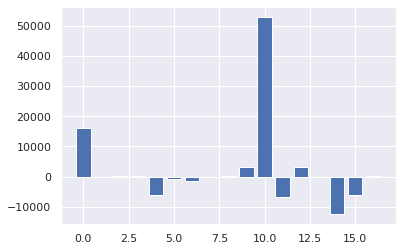

In [394]:
##modelo de regressão linear
lr_model = LinearRegression()
lr_model.fit(train_X, train_y) #treino
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(val_X) #predição

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #cálculo da acurácia da regressão linear

##importância de atributos
importance = lr_model.coef_
print("")
for i,v in enumerate(importance):
	print('Feature importance: %0d, Score: %.5f' % (i, v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

**Seleção simples de atributos para novo teste com o modelo de Regressão Linear:**

> A partir do resultado do cálculo da importância das features durante o treinamento do modelo Regressão Linear, as features que apresentaram scores de importância negativos foram retiradas dos conjuntos X de treino e teste.

> As features que apresentaram correlação negativa em relação aos atributos formadores da variável alvo, na etapa de EDA, também foram retiradas.

> **Assim, é possível observar que o modelo de regressão treinado com o novo conjunto de features apresentou métricas de acurácia superiores ao modelo anterior.**

In [395]:
#new_features = ['ACRES', 'ITER', 'OBJECTID', 'circular_variance', 'compactness', 'perimeter', 'weighted_convexity', 'eficiencia']
new_features = ['ACRES', 'ITER', 'OBJECTID', 'circular_variance', 'perimeter', 'eficiencia']

new_train_X=train_X[new_features]
new_val_X=val_X[new_features]

lr_model = LinearRegression()
lr_model.fit(new_train_X, train_y) #treino
#print(lr_model.score(train_X, train_y))

lr_prediction=lr_model.predict(new_val_X) #predição

calc_regression_metrics('Linear Regression', val_y, lr_prediction) #cálculo da acurácia da regressão linear

'Linear Regression prediction | Regression metric:'

r2: 0.7994148263706901
MAE: 590.3559922788396
MSE: 786193.5241199536


**3) Random Forest algorithm**

Teste com o algoritmo Random Forest utilizando o conjunto de features definido inicialmente. 

In [396]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=376)
rf_model.fit(train_X, train_y)
#print(rf_model.score(train_X, train_y))

rf_prediction=rf_model.predict(val_X) #predição

calc_regression_metrics('Random Forest', val_y, rf_prediction) #cálculo da acurácia da rf

'Random Forest prediction | Regression metric:'

r2: 0.6821745494416025
MAE: 774.461724137931
MSE: 1245716.7521827586


**4) Gradient Boosting algorithm for regression**

Teste com o algoritmo Gradient Boosting utilizando o conjunto de features definido inicialmente. 

In [397]:
gb_model = GradientBoostingRegressor(random_state=376)
gb_model.fit(train_X, train_y)
#print(xgb_model.score(train_X, train_y))

gb_prediction=gb_model.predict(val_X) #predição

calc_regression_metrics('Gradient Boosting', val_y, gb_prediction) #cálculo da acurácia do Gradient Boosting

'Gradient Boosting prediction | Regression metric:'

r2: 0.6733743010071397
MAE: 766.20942807782
MSE: 1280209.3231172757


# **Final remarks:**

> Para finalizar o exercício, nota-se que através da utilização de modelos de ML é possível estimar o tempo que um pulverizador finalizará uma ordem de serviço. Porém, existem variáveis que se mostram mais relevantes do que outras, como as features *ACRES e perimeter*, e que devem ser melhor consideradas visando o aumento da acurácia dos modelos de ML.

> Além disso, é necessário que ajustes mais finos sejam realizados para que as acurácias dos modelos e a qualidade das estimativas possam ser melhoradas. Por exemplo, é possível realizar um trabalho mais aprofundado de feature engineering e seleção de atributos visando selecionar features que descrevam de forma mais acertiva a variável resposta, cross-validation e otimização dos parâmetros do modelos de forma complementar.